In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.io import wavfile
from scipy.fftpack import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import soundfile as sf

In [51]:
def parse_table(filename):
    data_x = []
    data_y = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.strip():
                values = line.split()
                if values[0] == "*": continue
                freq = float(values[0])
                harmonic = float(values[1])
                data_x.append(freq)
                data_y.append(harmonic)
    return data_x, data_y

In [52]:
table_data = parse_table("test.txt")

In [53]:
x_data = np.array(table_data[0])
y_data = np.array(table_data[1])

<Axes: xlabel='X'>

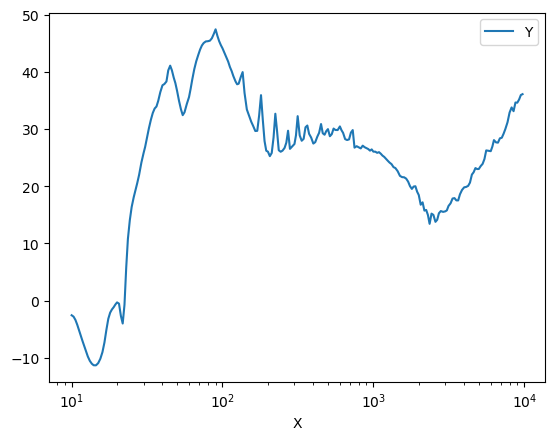

In [54]:
pd.DataFrame({"X": x_data,"Y": y_data}).set_index("X").plot(logx=True)

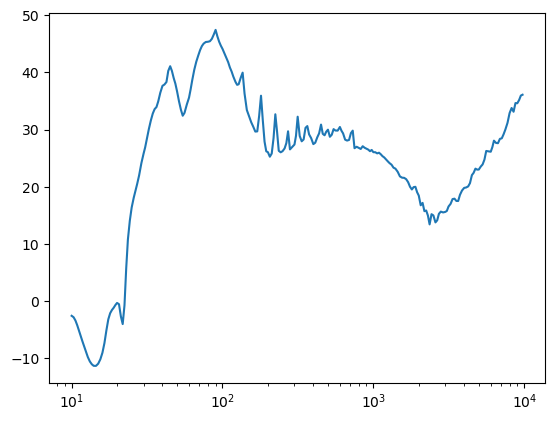

In [71]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_data, y_data)
ax.set_xscale("log")

In [72]:
def func(y, a, b, c, d, e, f, g, j):
    x = y * j
    return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 + g * x ** 6

In [75]:
popt, pcov = curve_fit(func, x_data, y_data)

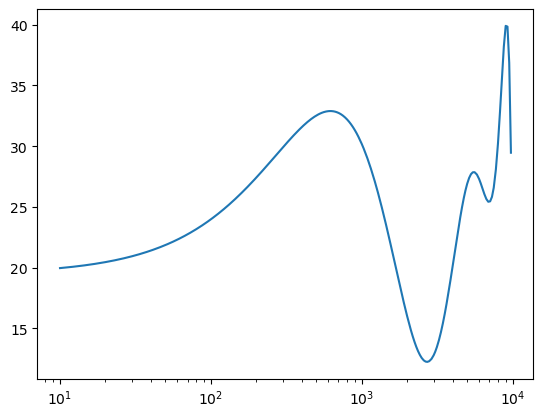

In [76]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.plot(x_data, func(x_data, *popt))
ax1.set_xscale("log")


## Signal only of even Harmonics test

In [101]:
def bandpass_filter(audio, lowcut, highcut, sample_rate, order=2):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, audio, padlen=25)
    return y

In [102]:
def generate_wav(filename, fundamental_freq, duration=1.0, sample_rate=44100, amplitude=0.1):
    """
    Generate a WAV file with a given fundamental frequency and its even harmonics.
    
    Args:
        filename (str): The name of the output WAV file.
        fundamental_freq (float): The fundamental frequency in Hz.
        duration (float): Duration of the signal in seconds.
        sample_rate (int): Sample rate in Hz.
        amplitude (float): Amplitude of the signal (between 0 and 1).
    """
    
    # Time array
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Create an array for the signal
    signal = np.zeros_like(t)
    signal = amplitude * np.sin(np.pi * fundamental_freq * t)
    # Add fundamental frequency and even harmonics
    for i in range(1, 222): 
        amp = amplitude * (float(1)/float(i)) * 0.01
        freq = fundamental_freq * ((i*2))
        harmonic = amp * np.sin( np.pi * freq * t)
        signal += bandpass_filter(harmonic, lowcut=freq-freq/10, highcut=freq+freq/10, sample_rate=sample_rate)
        
    # Normalize signal to fit in the 16-bit range
    signal = np.int16(signal / np.max(np.abs(signal)) * 32767)
    
    wavfile.write(filename, sample_rate, signal)

In [103]:
generate_wav("test.wav",45)

 ## EQ of only even harmonics test          

In [110]:
def amplify_harmonics( filename, fundamental, amplitude=0.1):
    audio, sample_rate = sf.read(filename)
    if audio.ndim > 1:
        audio = audio[:, 0]
    combined_audio = np.zeros_like(audio)
    for harm in range(1,222):
        freq = fundamental * (harm * 2)
        harmonics = bandpass_filter(audio,freq-(freq*0.1),freq+(freq*0.1),sample_rate) * (amplitude * (1/freq))
        combined_audio += harmonics
    combined_audio += audio
    sf.write(f'test_boost.wav', audio, sample_rate)

In [111]:
amplify_harmonics("test.wav",45)

In [3]:
audio, sample_rate = sf.read("Teminite & Boom Kitty - The Master [Beat Saber OST 7] [ ezmp3.cc ].mp3")

In [4]:
audio

array([[ 7.12802456e-11, -6.21784152e-11],
       [ 3.87224974e-11, -6.09981440e-11],
       [-3.85976182e-11, -2.28498227e-11],
       ...,
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00]])